In [474]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
import IPython
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

In [475]:
import opendatasets as od

# token 362de83c625279a01f8399c58a63abe8
od.download("https://www.kaggle.com/vinayshanbhag/bird-song-data-set")

Skipping, found downloaded files in "./bird-song-data-set" (use force=True to force download)


In [476]:
df = pd.read_csv('bird-song-data-set/bird_songs_metadata.csv')
df.sample(10)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
4315,62782,Melospiza,melodia,melodia,Song Sparrow,Mike Nelson,United States,"Knoxville, Tennessee",35.8589,-84.0948,200,song,//www.xeno-canto.org/62782,//creativecommons.org/licenses/by-nc-sa/3.0/,7:45am,2010-09-29,Two birds singing from either side of the road...,62782-4.wav
389,323977,Thryomanes,bewickii,eremophilus,Bewick's Wren,Richard E. Webster,United States,"San Bernardino National Wildlife Refuge, Cochi...",31.3400,-109.2730,1100,song,//www.xeno-canto.org/323977,//creativecommons.org/licenses/by-nc-sa/4.0/,07:24,2015-04-30,"singing in a cottonwood tree, by the end from ...",323977-6.wav
1903,54019,Mimus,polyglottos,polyglottos,Northern Mockingbird,Mike Nelson,United States,"Sunset Park, Las Vegas, Nevada",36.0628,-115.1128,300,song,//www.xeno-canto.org/54019,//creativecommons.org/licenses/by-nc-sa/3.0/,9:30am,2009-03-12,NaN,54019-3.wav
4208,111644,Melospiza,melodia,fallax,Song Sparrow,Richard E Webster,United States,"San Bernardino National Wildlife Refuge, Cochi...",31.3400,-109.2730,1100,song,//www.xeno-canto.org/111644,//creativecommons.org/licenses/by-nc-nd/2.5/,08:59,2011-05-04,first song a fragment,111644-3.wav
4337,18387,Melospiza,melodia,NaN,Song Sparrow,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/18387,//creativecommons.org/licenses/by-nc-nd/2.5/,09:35,2008-03-09,Singing from tops of shrubs and small trees ne...,18387-0.wav
2564,322887,Turdus,migratorius,NaN,American Robin,Peter Boesman,United States,"Nome, Nome, Alaska",64.5035,-165.4053,10,"call, song",//www.xeno-canto.org/322887,//creativecommons.org/licenses/by-nc-nd/4.0/,05:00,2016-06-02,NaN,322887-3.wav
5074,205836,Cardinalis,cardinalis,NaN,Northern Cardinal,Ross Gallardy,United States,"Honolulu, Honolulu County, Hawaii",21.2995,-157.7623,360,"male, song",//www.xeno-canto.org/205836,//creativecommons.org/licenses/by-nc-sa/4.0/,10:00,2014-12-07,NaN,205836-9.wav
556,217839,Thryomanes,bewickii,NaN,Bewick's Wren,Paul Marvin,United States,"Pine Creek Rd off Sunrise Hwy, Cleveland Natio...",32.9063,-116.4733,1600,"call, song",//www.xeno-canto.org/217839,//creativecommons.org/licenses/by-nc-sa/4.0/,11:47,2012-03-15,NaN,217839-8.wav
1860,58179,Mimus,polyglottos,NaN,Northern Mockingbird,Matthias Feuersenger,United States,"Hidden Valley, Joshua Tree National Park, Cali...",34.0150,-116.1580,1280,song,//www.xeno-canto.org/58179,//creativecommons.org/licenses/by-nc-nd/2.5/,06:00,2010-06-27,NaN,58179-3.wav
1132,470300,Mimus,polyglottos,NaN,Northern Mockingbird,Pat Goltz,United States,"Chuck Ford Lakeside Park (near Tucson), Pima ...",32.1863,-110.8183,800,song,//www.xeno-canto.org/470300,//creativecommons.org/licenses/by-nc-sa/4.0/,12:30,2019-04-12,NaN,470300-7.wav


In [477]:
directory = 'bird-song-data-set/wavfiles/'

In [478]:
df = df[['name', 'filename']]
df['filename'] = df['filename'].apply(lambda filename: directory + filename)

In [479]:
df.sample(5)

,name,filename
1954,Northern Mockingbird,bird-song-data-set/wavfiles/21735-11.wav
2224,American Robin,bird-song-data-set/wavfiles/483578-4.wav
2363,American Robin,bird-song-data-set/wavfiles/408817-17.wav
2713,American Robin,bird-song-data-set/wavfiles/310256-3.wav
2002,Northern Mockingbird,bird-song-data-set/wavfiles/18484-12.wav


In [480]:
def get_spectrogram(filepath=None, y=None, sr=None):
    if filepath:
        y, sr = librosa.load(filepath)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    return log_ms

In [481]:
def get_(filepath=None, y=None, sr=None):
    if filepath:
        y, sr = librosa.load(filepath)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    return log_ms

In [482]:
df['spectrogram'] = df['filename'].apply(get_spectrogram)
df.sample(5)

,name,filename,spectrogram
2413,American Robin,bird-song-data-set/wavfiles/383961-1.wav,"[[-55.120243, -57.467323, -59.601166, -59.2237..."
4488,Northern Cardinal,bird-song-data-set/wavfiles/483878-4.wav,"[[-75.4602, -80.0, -80.0, -80.0, -80.0, -80.0,..."
4921,Northern Cardinal,bird-song-data-set/wavfiles/321375-2.wav,"[[-27.824837, -31.506374, -32.541035, -28.1689..."
44,Bewick's Wren,bird-song-data-set/wavfiles/480035-3.wav,"[[-66.540886, -72.699844, -80.0, -80.0, -80.0,..."
3348,Song Sparrow,bird-song-data-set/wavfiles/425799-6.wav,"[[-20.104645, -17.667631, -21.151598, -22.6345..."


In [483]:
X = df[['spectrogram', 'filename']]
y = df['name']
x_max = np.max(np.abs(np.array(df['spectrogram'].tolist())))

In [484]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)


In [485]:
def get_important_x_y(x, y):
    x_new = x / x_max
    x_new = np.array(x_new.to_list())
    y_new = pd.get_dummies(np.array(y))
    return x_new, y_new

In [486]:
x_test_files = list(zip(list(x_test['filename']), list(y_test)))

In [487]:
x_train, y_train = get_important_x_y(x_train['spectrogram'], y_train)
x_test, y_test = get_important_x_y(x_test['spectrogram'], y_test)
x_val, y_val = get_important_x_y(x_val['spectrogram'], y_val)
print(x_train.shape, y_train.shape)

(3252, 128, 130) (3252, 5)


In [488]:
input_size = x_train[0].shape
input_size

(128, 130)

In [489]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_size))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 126, 32)           12512     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 63, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_36 (Conv1D)          (None, 61, 64)            6208      
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 30, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 28, 128)           24704     
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 14, 128)        

In [490]:
model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))
model.save('model')

Epoch 1/30
51/51 [==============================] - 2s 26ms/step - loss: 1.4272 - accuracy: 0.3462 - val_loss: 1.1535 - val_accuracy: 0.4682
Epoch 2/30
51/51 [==============================] - 1s 25ms/step - loss: 1.0987 - accuracy: 0.5037 - val_loss: 1.0347 - val_accuracy: 0.5336
Epoch 3/30
51/51 [==============================] - 1s 24ms/step - loss: 1.0118 - accuracy: 0.5372 - val_loss: 0.9208 - val_accuracy: 0.5908
Epoch 4/30
51/51 [==============================] - 1s 24ms/step - loss: 0.9326 - accuracy: 0.5886 - val_loss: 0.9033 - val_accuracy: 0.6203
Epoch 5/30
51/51 [==============================] - 1s 25ms/step - loss: 0.8685 - accuracy: 0.6245 - val_loss: 0.8494 - val_accuracy: 0.6295
Epoch 6/30
51/51 [==============================] - 1s 25ms/step - loss: 0.8539 - accuracy: 0.6301 - val_loss: 0.8447 - val_accuracy: 0.6221
Epoch 7/30
51/51 [==============================] - 1s 24ms/step - loss: 0.8130 - accuracy: 0.6424 - val_loss: 0.8520 - val_accuracy: 0.6230
Epoch 8/30
51

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [491]:
model = tf.keras.models.load_model('model')

In [492]:
test_loss, test_acc = model.evaluate(x_test, y_test)

34/34 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.8018


In [503]:
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
embeddings = embedding_model.predict(x_test)

34/34 [==============================] - 0s 4ms/step


In [504]:
print(embeddings)

[[9.829729   2.8446555  7.1199     ... 0.         7.592181   5.1737986 ]
 [6.7829385  3.4176857  5.794635   ... 0.         7.250085   4.750085  ]
 [0.         1.6985834  1.1719005  ... 3.9441433  4.608528   4.596369  ]
 ...
 [0.         0.         0.         ... 0.         5.0202146  0.11787451]
 [1.5589547  4.460737   0.         ... 0.         3.492853   1.4017856 ]
 [1.4116826  2.1491718  1.1942574  ... 0.18693052 4.6165185  2.7263963 ]]


In [505]:
X = umap.UMAP().fit_transform(embeddings)

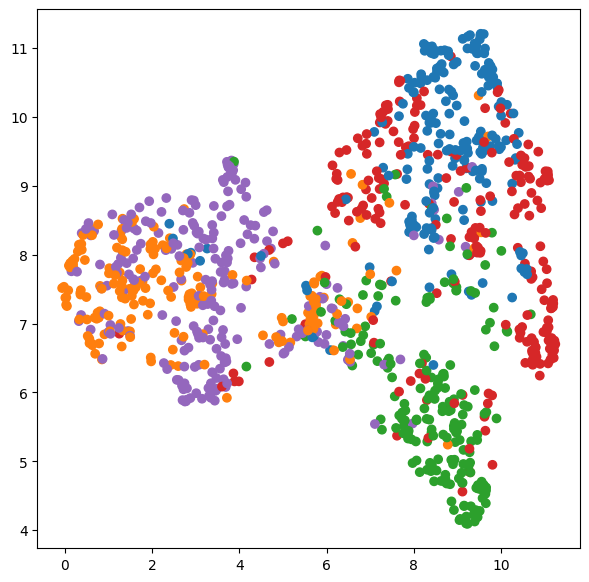

In [506]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.scatter(X[:, 0], X[:, 1], color=[sns.color_palette()[number] for number in y_test.apply(np.argmax, axis=1)])
plt.show()

In [513]:
vector = list(embeddings)
vector_names = list(x_test_files)

In [514]:
def get_nearest_vectors(vector) -> (int, int):
    distances = pdist(vector)
    n = len(vector)
    return np.unravel_index(np.argmin(distances), (n, n))

In [515]:
i1, i2 = get_nearest_vectors(vector)
print(vector_names[i1])
print(vector_names[i2])

In [510]:
IPython.display.Audio(vector_names[i1][0])

In [511]:
IPython.display.Audio(vector_names[i2][0])

In [512]:
del vector[i1]
del vector_names[i1]